In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

In [2]:
# Load CSV into a pandas DataFrame
df = pd.read_csv(
    'Checkme O2 _20250114084307.csv',
    parse_dates=['Time'],
    date_format='%H:%M:%S %b %d %Y'
)

# Set Time as the index
df.set_index('Time', inplace=True)

In [3]:
# Remove non-numeric values from df["Oxygen Level"]
df["Oxygen Level"] = pd.to_numeric(df["Oxygen Level"], errors='coerce')

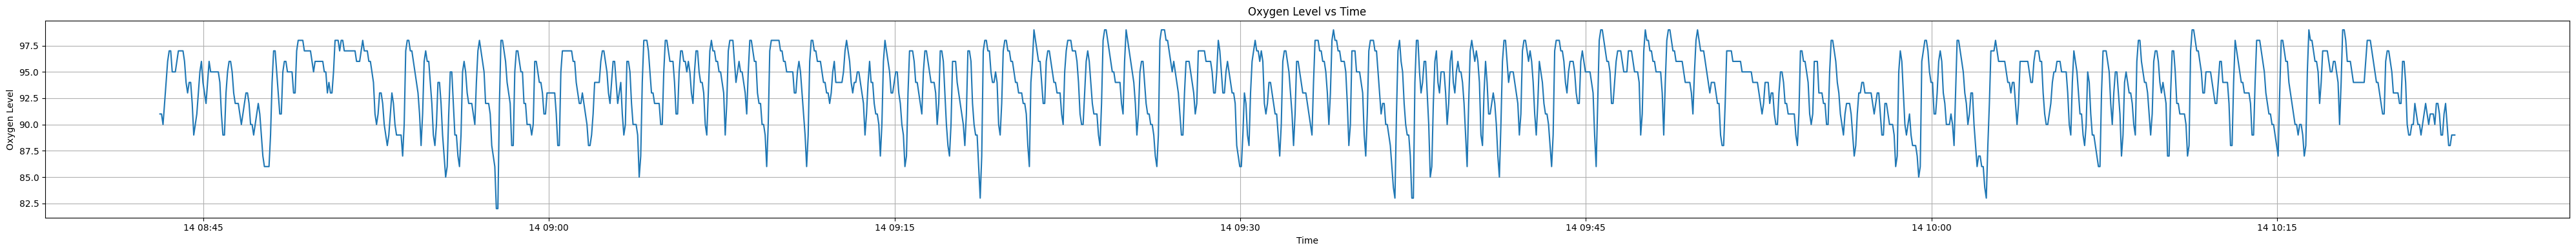

In [4]:
# Plot Oxygen Level vs. Time
plt.figure(figsize=(40, 4))
plt.plot(df.index, df['Oxygen Level'])
plt.xlabel('Time')
plt.ylabel('Oxygen Level')
plt.title('Oxygen Level vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

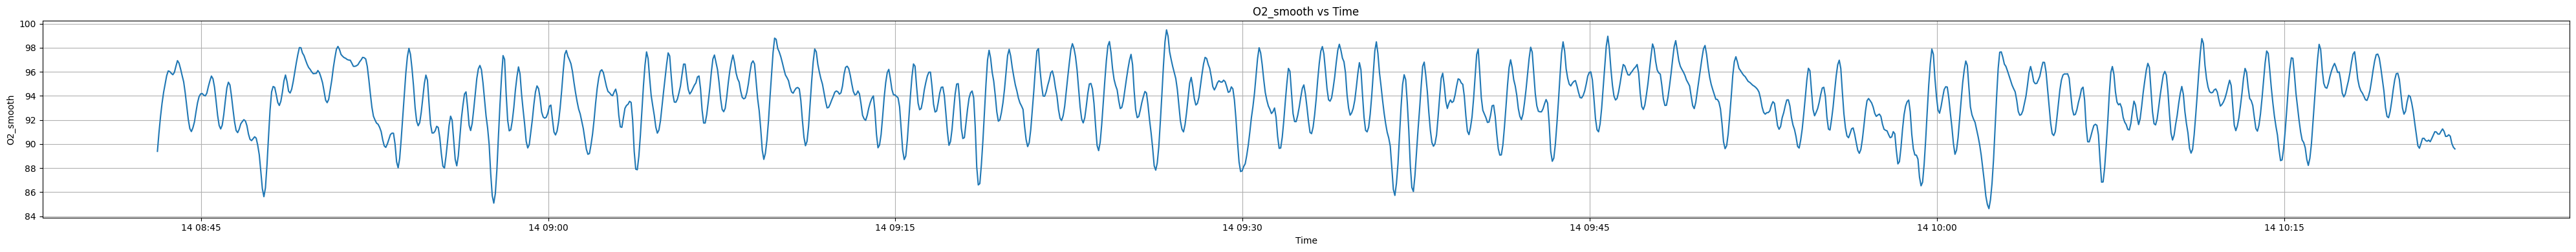

In [5]:
# Smooth the data series and plot it again
df["O2_smooth"] = savgol_filter(df["Oxygen Level"], window_length=11, polyorder=2)

plt.figure(figsize=(40, 4))
plt.xlabel('Time')
plt.ylabel('O2_smooth')
plt.title('O2_smooth vs Time')
plt.grid(True)
plt.tight_layout()
plt.plot(df.index, df['O2_smooth'])

In [6]:
PEAK_MIN_DISTANCE = 10  # min distance between peaks in "number of samples"
PEAK_PROMINENCE = 5     # min vertical distance (in O2 units) that a peak should stand out

In [7]:
# Use the smoothed O2 data to find peaks
y = df["O2_smooth"].values

# Find_peaks returns indices in the array that are peak positions
peak_indices, peak_dict = find_peaks(
    y,
    distance=PEAK_MIN_DISTANCE,
    prominence=PEAK_PROMINENCE
)

# Convert indices back to your DataFrame index (Time) if you like:
peak_times = df.index[peak_indices]

events = []  # to hold (max1_idx, min_idx, max2_idx) for each event

for i in range(len(peak_indices) - 1):
    # Start and end of one respiratory cycle
    start_idx = peak_indices[i]
    end_idx   = peak_indices[i + 1]
    
    # Slice the O2 array in between these two peaks
    segment = y[start_idx : end_idx + 1]
    
    # Find the index of the min in this segment (relative to segment)
    min_local_idx = np.argmin(segment)
    
    # Convert that to an absolute index in the full data
    actual_min_idx = start_idx + min_local_idx
    
    # Store the triple: (start_of_cycle, the_minimum, next_peak)
    events.append((peak_indices[i], actual_min_idx, peak_indices[i+1]))

# If you want them as Timestamps:
#events_time = [x
#    (df.index[a], df.index[b], df.index[c]) 
#    for (a,b,c) in events
#]

In [8]:
analysis = []
for (max1, min_, max2) in events:
    o2_max1 = y[max1]
    o2_min  = y[min_]
    o2_max2 = y[max2]
    
    time_max1 = df.index[max1]
    time_min  = df.index[min_]
    time_max2 = df.index[max2]
    
    drop_amp = o2_max1 - o2_min  # how much O2 level dropped
    duration = (time_max2 - time_max1).total_seconds() / 60.0  # in minutes, e.g.
    
    analysis.append({
        "start_time": time_max1,
        "min_time": time_min,
        "end_time": time_max2,
        "start_O2": o2_max1,
        "min_O2":   o2_min,
        "end_O2":   o2_max2,
        "drop_amp": drop_amp,
        "duration": duration
    })

analysis_df = pd.DataFrame(analysis)

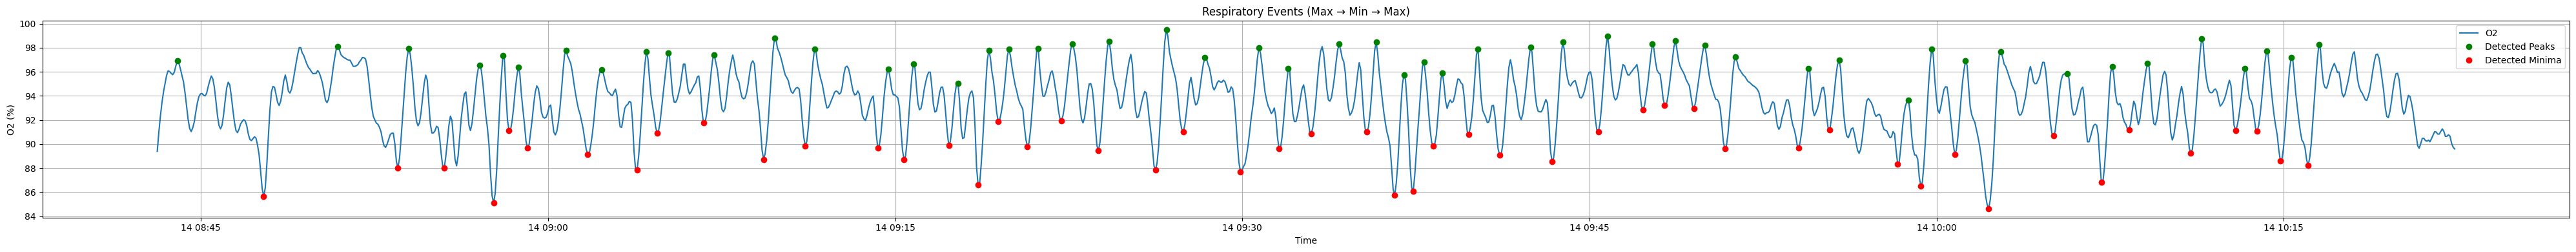

In [9]:
fig, ax = plt.subplots(figsize=(40, 4))

# Plot raw or smoothed signal
ax.plot(df.index, y, label="O2")

# Mark the maxima
ax.plot(df.index[peak_indices], y[peak_indices], 'go', label="Detected Peaks")

# Mark the minima
minima_indices = [ev[1] for ev in events]
ax.plot(df.index[minima_indices], y[minima_indices], 'ro', label="Detected Minima")

ax.set_xlabel("Time")
ax.set_ylabel("O2 (%)")
ax.set_title("Respiratory Events (Max → Min → Max)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()